In [1]:
!kaggle datasets download -d  harishvutukuri/dogs-vs-wolves -p data

dogs-vs-wolves.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q -u data/dogs-vs-wolves.zip -d data/dogs-vs-wolves

## Imports

In [3]:
# Torch #
import torch

# Torchero #
import torchero
from torchero.utils.data import train_test_split # split train dataset into train and val
from torchero.utils import show_imagegrid_dataset # display the dataset (optional)
from torchero.models.vision import BinaryImageClassificationModel # Computer vision Model for Binary label classification
from torchero.utils.vision import datasets, transforms, download_images # Vision utils
from torchero.callbacks import ProgbarLogger # Report training

# Matplotlib #
from matplotlib import pyplot as plt

## Training dataset

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

In [5]:
dataset = datasets.ImageFolder(root='../../data/dogs-vs-wolves/data', transform=transform)

In [6]:
dataset.classes

['dogs', 'wolves']

In [7]:
train_ds, val_ds = train_test_split(dataset)

Since we splitted in train and test using train_test_split (which without passing any valid_size uses 20% by default) the training set should be 80% of the size of the dataset before the splitting.

In [8]:
print(len(train_ds), len(val_ds))

1600 400


If we obtain the first item of the dataset we should have an image of size 3x224x224 (defined in the transform operator) and a single float where:

* 0 represents the negative class (dog)
* 1 represents the positive class (wolf)

the order from which class is positive and which class is negative comes from the ``dataset.classes`` property

In [9]:
X, y = train_ds[0]
print(X.shape, y)

torch.Size([3, 224, 224]) 0


### Train dataset

Lets visualize some samples of the train dataset by its class

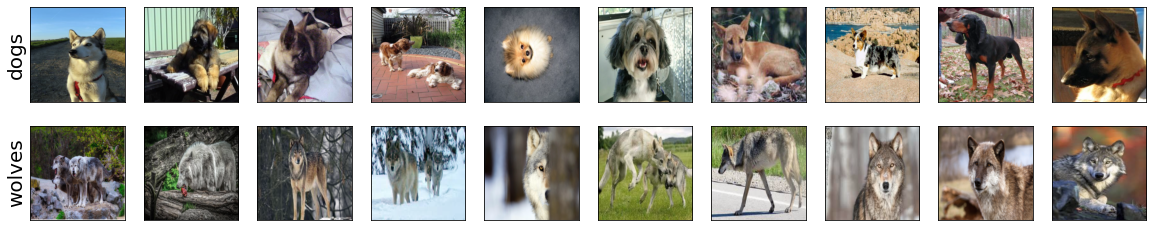

In [10]:
show_imagegrid_dataset(train_ds)

### Test dataset

And lets do the same for val_ds to see that there are some obvious bias.

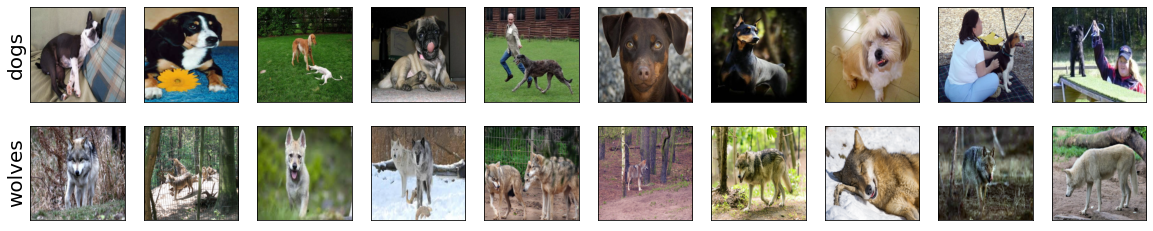

In [11]:
show_imagegrid_dataset(val_ds)

## Model

Let's use the BinaryImageClassificationModel to load a pretrained version of resnet18 using ``BinaryImageClassificationModel.from_pretrained`` class method. This method also handles the adaptation of the last layer (the classifier one) to our number of outputs. The transform parameters is the transformation that is going to be used at prediction time (that we will use later to test with some random dog and wolf image).

After defining the model we need to compile it with an optimizer (`adam` for this case) a number of callbacks (for this case we only will display the training progress bar). If we omit the metrics in the compile method the most common used metrics for multilabel classification will be used (e.g. recall, precision and f1-score).

In [12]:
model = (BinaryImageClassificationModel.from_pretrained('resnet18',
                                                        num_outputs=1,
                                                        transform=transform)
                                       .compile(optimizer='adam',
                                                callbacks=[ProgbarLogger(notebook=True)]))

In [13]:
model.labels = ['is_wolf']

If we are running the notebook with a hardware that support CUDA we can move the model to the GPU using ``model.cuda()`` (or ``model.to('cuda')`` in the same way we do for torch ``nn.Module``'s

In [14]:
if torch.cuda.is_available():
    model.cuda()

## Train model

Given that this dataset is not so big so we can train the model for 10 epochs to achieve a good performance and also because the model doesn't have a lot of parameters like ``resnet152`` we can set a reasonably high batch size

In [15]:
history = model.fit(train_ds,
                    val_ds,
                    batch_size=256,
                    epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

  0%|          | 0/7 [00:00<?, ? batchs/s]

### Training results

Not surprisingly, the model achieves a good performance due to the fact that ``ImageNet``, the dataset from which the pretrained model was trained, already contained those classes

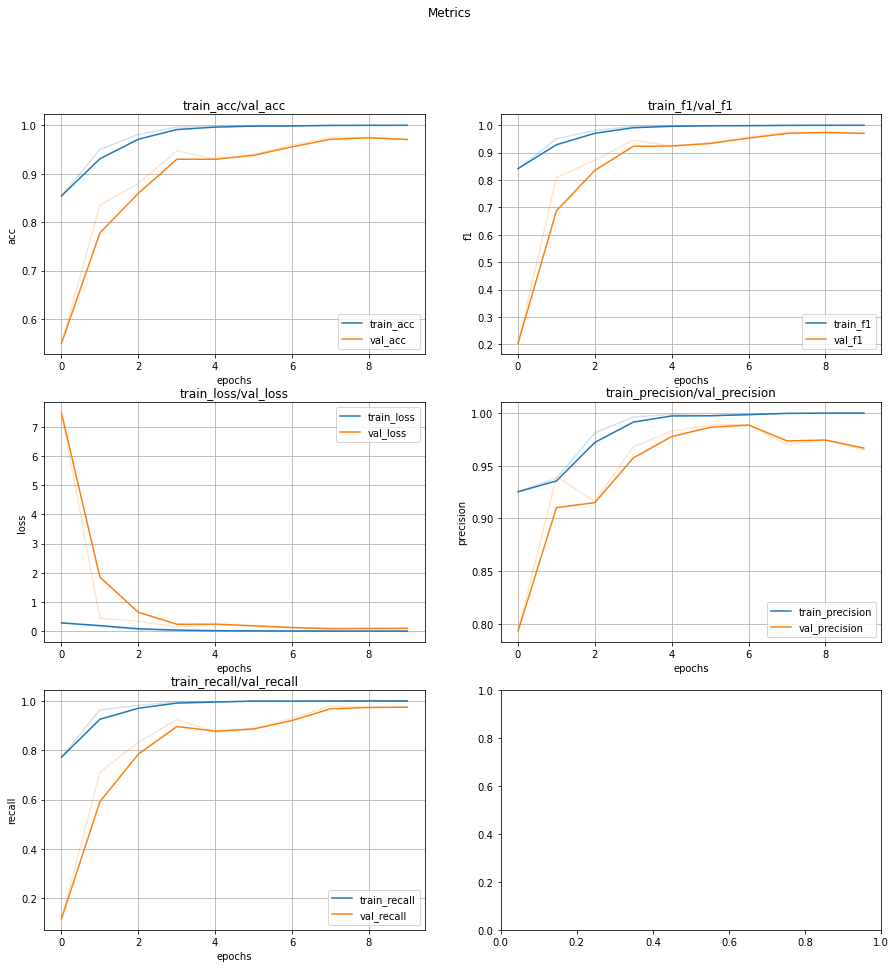

In [16]:
history.plot(smooth=0.2)
plt.show()

### Classification report

In [17]:
model.classification_report(val_ds)

{'is_wolf': {'precision': 0.9648241400718689,
  'recall': 0.9746192693710327,
  'f1-score': 0.9696970582008362,
  'support': 197}}

## Test the model with some random images

In [18]:
ims = download_images(["https://upload.wikimedia.org/wikipedia/commons/d/d3/Grey_wolf_P1130270.jpg",
                       "https://live.staticflickr.com/3052/3086132328_e2041be795_b.jpg"])
ims = list(ims)

100%|██████████| 2/2 [00:06<00:00,  3.19s/image]


In [19]:
preds = (model.predict(ims).as_df()>0.5).replace({True: 'wolf', False: 'dog'}).is_wolf.tolist()

/usr/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


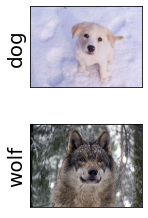

In [20]:
show_imagegrid_dataset(list(zip(ims,
                                preds)))